<a href="https://colab.research.google.com/github/hu-tianyi/AIPI531/blob/main/AIPI531_HW2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI531 HW2
Tianyi Hu

# DQN and Double DQN with Stable-Baselines3

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Double Q-Learning: https://paperswithcode.com/method/double-q-learning


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

## Introduction

In this notebook, we will study DQN using Stable-Baselines3 and then see how to reduce value overestimation with double DQN.

## Installation

We will install master version of SB3.

In [1]:
# for autoformatting
# %load_ext jupyter_black

In [2]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization

!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libice-dev libopengl-dev libsm-dev libxfont2 libxkbfile1
  libxt-dev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libice-doc libsm-doc libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev
  libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libice-dev libopengl-dev libsm-dev libxfont2
  libxkbfile1 libxt-dev x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 25 newly installed, 0 to remove and 18 not upgraded.
Ne

Import DQN and evaluation helper

In [3]:
import gymnasium as gym
import numpy as np
import torch as th
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## The Mountain Car Problem

In this environment, the agent must drive an underpowered car up a steep mountain road. For any given state the agent may choose to accelerate to the left, right or cease any acceleration.

Source: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/mountain_car.py

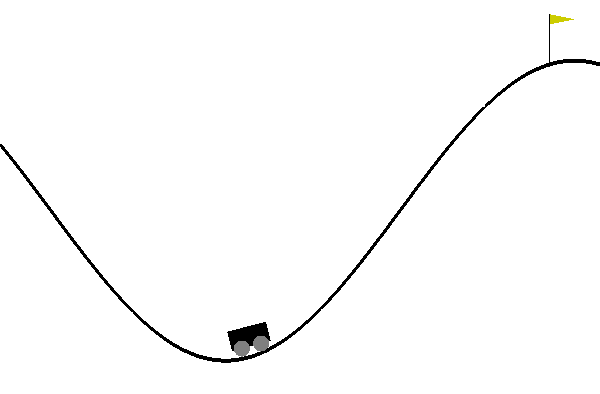


    Observation:
        Type: Box(2)
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07
    Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        Note: This does not affect the amount of velocity affected by the
        gravitational pull acting on the car.
    Reward:
         Reward of 0 is awarded if the agent reached the flag (position = 0.5)
         on top of the mountain.
         Reward of -1 is awarded if the position of the agent is less than 0.5.
    Starting State:
         The position of the car is assigned a uniform random value in
         [-0.6 , -0.4].
         The starting velocity of the car is always assigned to 0.
    Episode Termination:
         The car position is more than 0.5
         Episode length is greater than 200



Create the environment

In [4]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create the model with tuned hyperparameters from the RL Zoo

```yaml
MountainCar-v0:
  n_timesteps: !!float 1.2e5
  policy: 'MlpPolicy'
  learning_rate: !!float 4e-3
  batch_size: 128
  buffer_size: 10000
  learning_starts: 1000
  gamma: 0.98
  target_update_interval: 600
  train_freq: 16
  gradient_steps: 8
  exploration_fraction: 0.2
  exploration_final_eps: 0.07
  policy_kwargs: "dict(net_arch=[256, 256])"
```

In [5]:
tensorboard_log = "data/tb/"

In [6]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=2,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the agent before training

In [7]:
mean_reward, std_reward = evaluate_policy(
    dqn_model,
    dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-200.00 +/- 0.00


In [8]:
# Optional: Monitor training in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir $tensorboard_log

We will first train the agent until convergence and then analyse the learned q-value function.

In [9]:
dqn_model.learn(int(1.2e5), log_interval=10)

Logging to data/tb/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 608      |
|    time_elapsed     | 3        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 1.97e-05 |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.845    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 359      |
|    time_elapsed     | 11       |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 9.68e-

Evaluate after training, the mean episodic reward should have improved.

In [10]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-104.00 +/- 9.80


### Prepare video recording

In [11]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [12]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

We will record a video using the [VecVideoRecorder](https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecvideorecorder) wrapper, you will learn about those wrapper in the next notebook.

In [13]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(
    env_id,
    model,
    video_length=500,
    prefix="",
    video_folder="videos/",
):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Visualize trained agent

In [14]:
record_video("MountainCar-v0", dqn_model, video_length=500, prefix="dqn-mountaincar")

Saving video to /content/videos/dqn-mountaincar-step-0-to-step-500.mp4
Moviepy - Building video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/dqn-mountaincar-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn-mountaincar-step-0-to-step-500.mp4


In [15]:
show_videos("videos", prefix="dqn")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualize Q-values

### Exercise (5 minutes): Retrieve q-values

The function will be used to retrieve the learned q-values for a given state (`observation` in the code).

The q-network from SB3 DQN can be accessed via `model.q_net` and is a PyTorch module (you can therefore call `.forward()` on it).

You need to convert the observation to a PyTorch tensor and then convert the resulting q-values to numpy array.

Note: It is recommended to use `with th.no_grad():` context to save computation and memory

In [16]:
def get_q_values(model: DQN, obs: np.ndarray) -> np.ndarray:
    """
    Retrieve Q-values for a given observation.

    :param model: a DQN model
    :param obs: a single observation
    :return: the associated q-values for the given observation
    """
    assert model.get_env().observation_space.contains(obs), f"Invalid observation of shape {obs.shape}: {obs}"
    ### YOUR CODE HERE
    # Retrieve q-values for the given observation and convert them to numpy

    # pack the observation in mini-batch as a tensor
    obs_t = th.tensor(obs, dtype=th.float32).unsqueeze(0)

    # model inference
    with th.no_grad():
        q_values_t = model.q_net.forward(obs_t)

    # Convert tensor back to numpy array
    q_values = q_values_t.squeeze(0).numpy()

    ### END OF YOUR CODE
    assert isinstance(q_values, np.ndarray), "The returned q_values is not a numpy array"
    assert q_values.shape == (3,), f"Wrong shape: (3,) was expected but got {q_values.shape}"

    return q_values

### Q-values for the initial state

Let's reset the environment to start a new episode:

In [17]:
obs, _ = env.reset()

we plot the rendered environment to visualize it

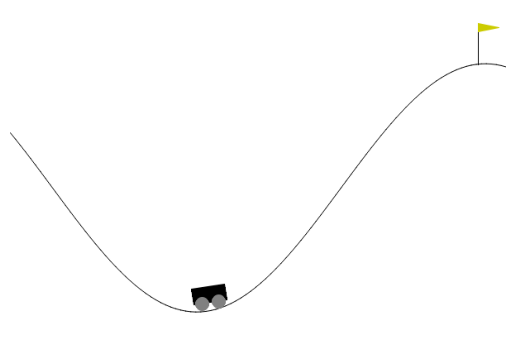

In [18]:
plt.axis('off')
plt.imshow(env.render())

### Exercise (5 minutes): predict taken action according to q-values

Using the `get_q_values()` function, retrieve the q-values for the initial observation, print them for each action ("left", "nothing", "right") and print the action that the greedy (deterministic) policy would follow (i.e., the action with the highest q-value for that state).

In [19]:
action_str = ["Left", "Nothing", "Right"]  # action=0 -> go left, action=1 -> do nothing, action=2 -> go right

In [20]:
### YOUR CODE HERE
# Retrieve q-values for the initial state
# You should use `get_q_values()`

q_values = get_q_values(dqn_model, obs)

# Extract individual Q-values for each possible action
q_value_left, q_value_nothing, q_value_right = q_values

### END OF YOUR CODE

print(f"Q-value of the initial state left={q_value_left:.2f} nothing={q_value_nothing:.2f} right={q_value_right:.2f}")

### YOUR CODE HERE
# Compute the action taken in the initilal state according to q-values
# when following a greedy strategy

# choose the action with max Q-value
action = np.argmax(q_values)

## END of your code here

print(f"Action taken by the greedy policy in the initial state: {action_str[action]}")

Q-value of the initial state left=-59.92 nothing=-60.29 right=-59.90
Action taken by the greedy policy in the initial state: Right


The q-value of the initial state corresponds to how much (discounted) reward the agent expects to get in this episode.

We will compare the estimated q-value to the discounted return of the episode.

In [21]:
initial_q_value = q_values.max()
initial_q_value

-59.896885

## Step until the end of the episode



Q-value of the current state left=-59.92 nothing=-60.29 right=-59.90
Action: Right
Q-value of the current state left=-59.88 nothing=-60.15 right=-59.76
Action: Right
Q-value of the current state left=-59.63 nothing=-59.77 right=-59.39
Action: Right
Q-value of the current state left=-59.33 nothing=-59.35 right=-59.00
Action: Right


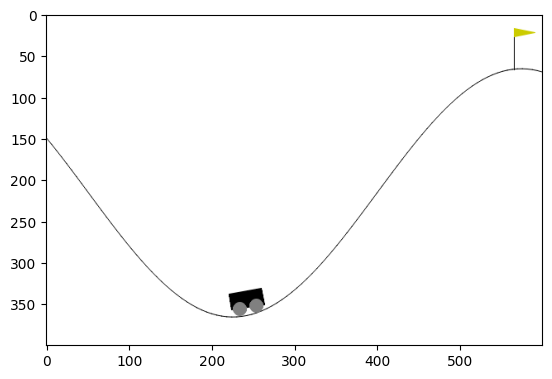

Q-value of the current state left=-59.02 nothing=-59.02 right=-58.70
Action: Right
Q-value of the current state left=-58.79 nothing=-58.81 right=-58.54
Action: Right
Q-value of the current state left=-58.61 nothing=-58.69 right=-58.50
Action: Right
Q-value of the current state left=-58.39 nothing=-58.53 right=-58.45
Action: Left
Q-value of the current state left=-58.17 nothing=-58.37 right=-58.29
Action: Left


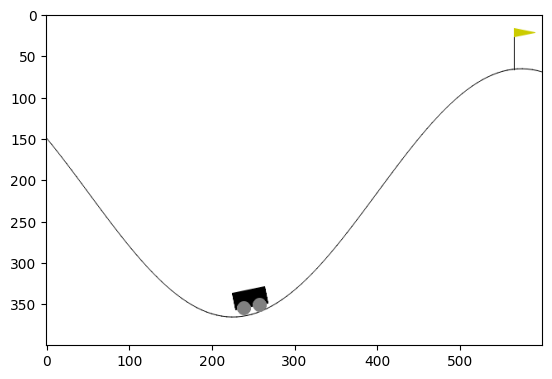

Q-value of the current state left=-57.67 nothing=-57.88 right=-57.81
Action: Left
Q-value of the current state left=-57.03 nothing=-57.30 right=-57.22
Action: Left
Q-value of the current state left=-56.62 nothing=-57.02 right=-56.90
Action: Left
Q-value of the current state left=-56.46 nothing=-57.03 right=-56.89
Action: Left
Q-value of the current state left=-56.42 nothing=-57.18 right=-57.02
Action: Left


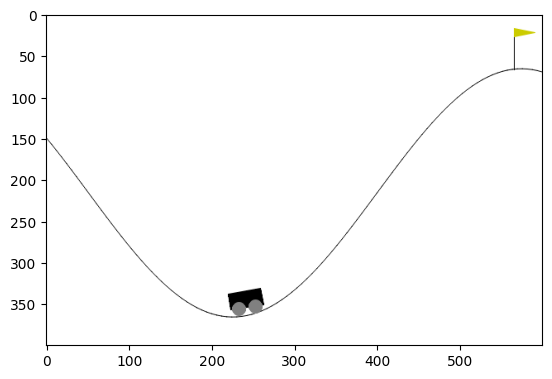

Q-value of the current state left=-56.29 nothing=-57.17 right=-57.04
Action: Left
Q-value of the current state left=-56.10 nothing=-57.04 right=-56.97
Action: Left
Q-value of the current state left=-56.14 nothing=-57.22 right=-57.23
Action: Left
Q-value of the current state left=-55.23 nothing=-56.48 right=-56.66
Action: Left
Q-value of the current state left=-55.08 nothing=-56.38 right=-56.68
Action: Left


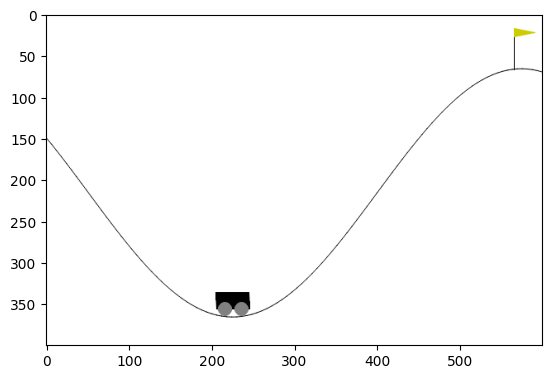

Q-value of the current state left=-54.45 nothing=-55.78 right=-56.26
Action: Left
Q-value of the current state left=-53.49 nothing=-54.82 right=-55.62
Action: Left
Q-value of the current state left=-52.93 nothing=-54.32 right=-55.41
Action: Left
Q-value of the current state left=-52.94 nothing=-54.44 right=-55.78
Action: Left
Q-value of the current state left=-52.67 nothing=-54.28 right=-55.83
Action: Left


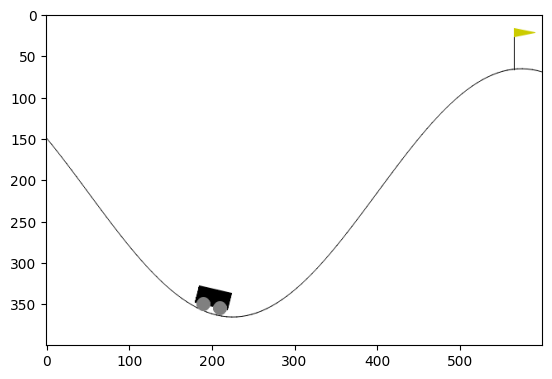

Q-value of the current state left=-52.34 nothing=-54.08 right=-55.83
Action: Left
Q-value of the current state left=-51.75 nothing=-53.53 right=-55.28
Action: Left
Q-value of the current state left=-51.19 nothing=-53.00 right=-54.77
Action: Left
Q-value of the current state left=-50.66 nothing=-52.49 right=-54.28
Action: Left
Q-value of the current state left=-50.58 nothing=-52.37 right=-54.15
Action: Left


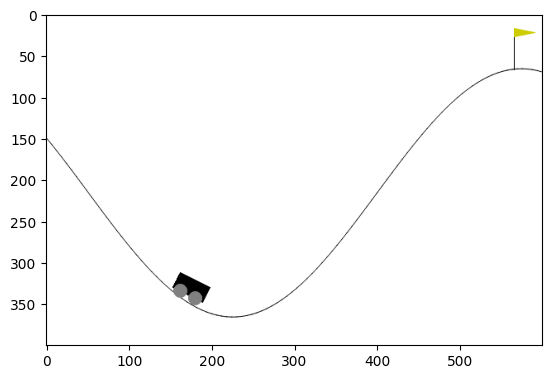

Q-value of the current state left=-50.60 nothing=-52.37 right=-54.16
Action: Left
Q-value of the current state left=-50.53 nothing=-52.31 right=-54.12
Action: Left
Q-value of the current state left=-49.84 nothing=-51.60 right=-53.33
Action: Left
Q-value of the current state left=-49.31 nothing=-51.03 right=-52.69
Action: Left
Q-value of the current state left=-48.97 nothing=-50.65 right=-52.25
Action: Left


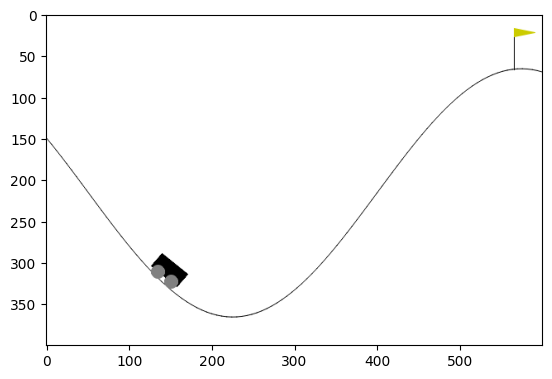

Q-value of the current state left=-48.78 nothing=-50.44 right=-51.99
Action: Left
Q-value of the current state left=-48.68 nothing=-50.34 right=-51.87
Action: Left
Q-value of the current state left=-48.54 nothing=-50.18 right=-51.66
Action: Left
Q-value of the current state left=-48.04 nothing=-49.47 right=-50.72
Action: Left
Q-value of the current state left=-47.66 nothing=-48.94 right=-50.00
Action: Left


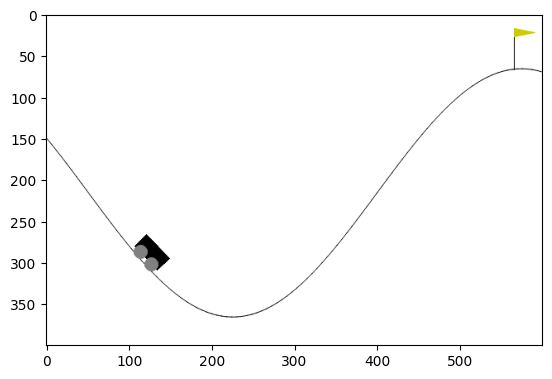

Q-value of the current state left=-47.35 nothing=-48.53 right=-49.46
Action: Left
Q-value of the current state left=-47.09 nothing=-48.24 right=-49.09
Action: Left
Q-value of the current state left=-46.31 nothing=-47.21 right=-47.72
Action: Left
Q-value of the current state left=-45.33 nothing=-45.90 right=-45.99
Action: Left
Q-value of the current state left=-44.43 nothing=-44.75 right=-44.53
Action: Left


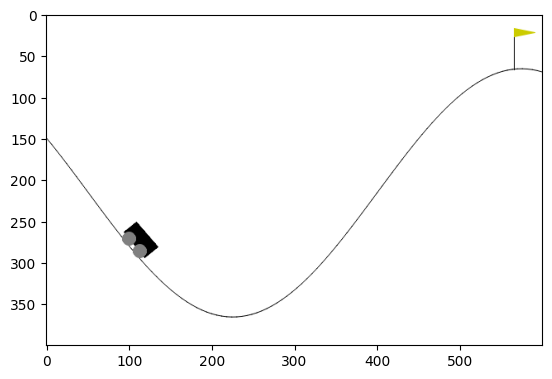

Q-value of the current state left=-43.95 nothing=-44.22 right=-43.99
Action: Left
Q-value of the current state left=-43.61 nothing=-43.88 right=-43.65
Action: Left
Q-value of the current state left=-43.22 nothing=-43.49 right=-43.26
Action: Left
Q-value of the current state left=-42.96 nothing=-43.20 right=-42.96
Action: Left
Q-value of the current state left=-42.88 nothing=-43.05 right=-42.80
Action: Right


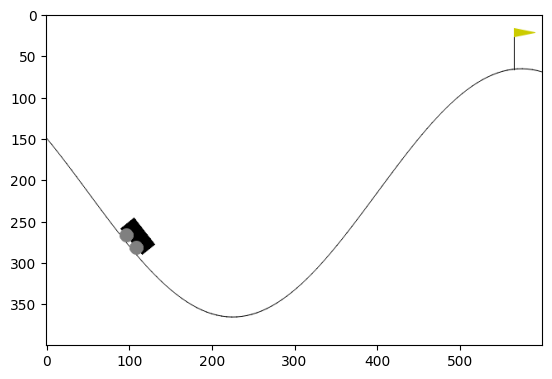

Q-value of the current state left=-43.22 nothing=-43.18 right=-42.80
Action: Right
Q-value of the current state left=-43.23 nothing=-42.99 right=-42.46
Action: Right
Q-value of the current state left=-43.33 nothing=-42.87 right=-42.19
Action: Right
Q-value of the current state left=-43.02 nothing=-42.37 right=-41.58
Action: Right
Q-value of the current state left=-42.57 nothing=-41.72 right=-40.82
Action: Right


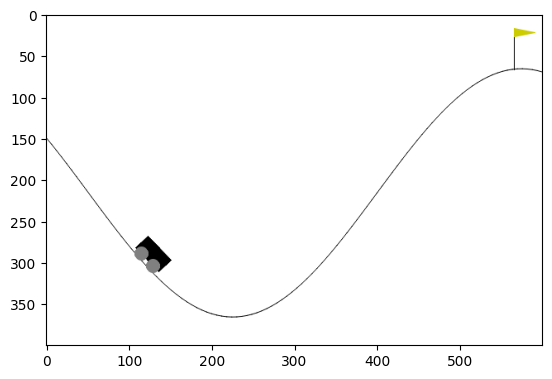

Q-value of the current state left=-42.71 nothing=-41.57 right=-40.50
Action: Right
Q-value of the current state left=-41.76 nothing=-40.45 right=-39.35
Action: Right
Q-value of the current state left=-40.96 nothing=-39.42 right=-38.29
Action: Right
Q-value of the current state left=-40.74 nothing=-38.93 right=-37.70
Action: Right
Q-value of the current state left=-40.92 nothing=-38.83 right=-37.45
Action: Right


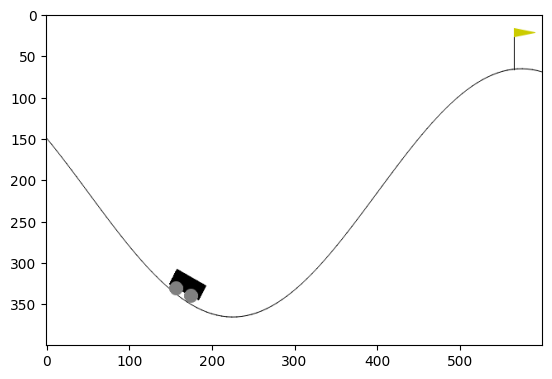

Q-value of the current state left=-40.67 nothing=-38.34 right=-36.82
Action: Right
Q-value of the current state left=-40.19 nothing=-37.64 right=-35.93
Action: Right
Q-value of the current state left=-40.74 nothing=-37.81 right=-35.75
Action: Right
Q-value of the current state left=-41.07 nothing=-37.81 right=-35.55
Action: Right
Q-value of the current state left=-41.42 nothing=-37.92 right=-35.57
Action: Right


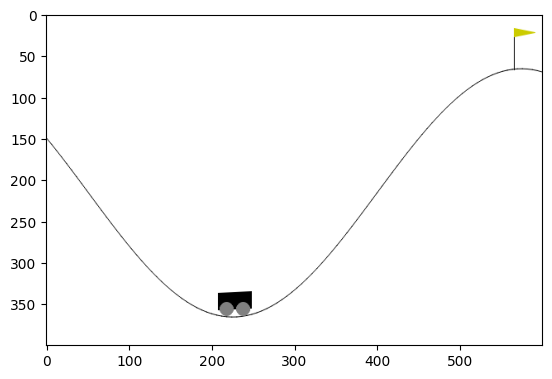

Q-value of the current state left=-40.63 nothing=-36.79 right=-34.44
Action: Right
Q-value of the current state left=-41.34 nothing=-37.54 right=-34.74
Action: Right
Q-value of the current state left=-41.53 nothing=-37.80 right=-34.52
Action: Right
Q-value of the current state left=-41.10 nothing=-37.17 right=-33.73
Action: Right
Q-value of the current state left=-39.93 nothing=-35.74 right=-32.73
Action: Right


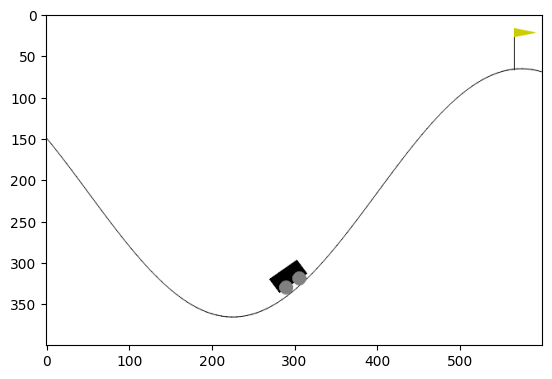

Q-value of the current state left=-39.22 nothing=-35.09 right=-32.46
Action: Right
Q-value of the current state left=-36.70 nothing=-32.67 right=-29.99
Action: Right
Q-value of the current state left=-34.21 nothing=-30.19 right=-27.45
Action: Right
Q-value of the current state left=-32.99 nothing=-29.16 right=-26.33
Action: Right
Q-value of the current state left=-32.24 nothing=-28.81 right=-25.89
Action: Right


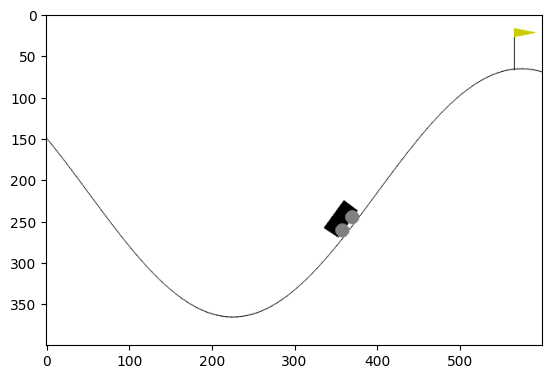

Q-value of the current state left=-31.89 nothing=-29.02 right=-26.02
Action: Right
Q-value of the current state left=-31.56 nothing=-29.02 right=-26.05
Action: Right
Q-value of the current state left=-30.68 nothing=-28.28 right=-25.44
Action: Right
Q-value of the current state left=-30.19 nothing=-28.01 right=-25.29
Action: Right
Q-value of the current state left=-29.98 nothing=-28.08 right=-25.48
Action: Right


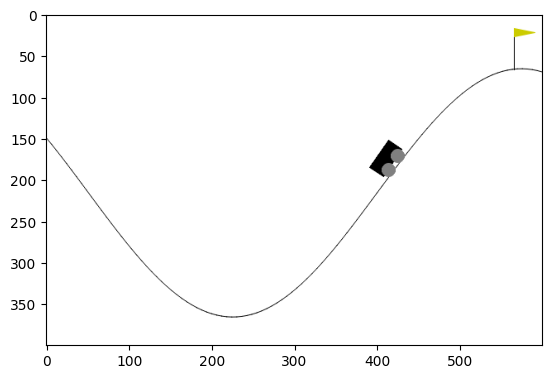

Q-value of the current state left=-29.99 nothing=-28.41 right=-25.92
Action: Right
Q-value of the current state left=-29.91 nothing=-28.59 right=-26.24
Action: Right
Q-value of the current state left=-28.22 nothing=-26.53 right=-24.54
Action: Right
Q-value of the current state left=-26.63 nothing=-24.60 right=-22.94
Action: Right
Q-value of the current state left=-25.11 nothing=-22.75 right=-21.41
Action: Right


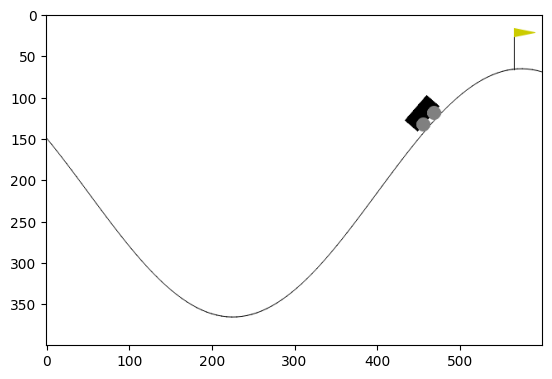

Q-value of the current state left=-23.63 nothing=-20.96 right=-19.92
Action: Right
Q-value of the current state left=-22.31 nothing=-19.48 right=-18.54
Action: Right
Q-value of the current state left=-21.15 nothing=-18.37 right=-17.45
Action: Right
Q-value of the current state left=-20.11 nothing=-17.53 right=-16.69
Action: Right
Q-value of the current state left=-19.31 nothing=-16.92 right=-16.13
Action: Right


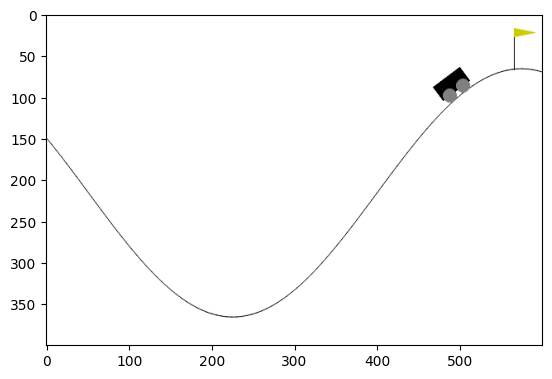

Q-value of the current state left=-18.48 nothing=-16.27 right=-15.52
Action: Right
Q-value of the current state left=-17.62 nothing=-15.56 right=-14.87
Action: Right
Q-value of the current state left=-16.70 nothing=-14.80 right=-14.16
Action: Right
Q-value of the current state left=-15.74 nothing=-13.98 right=-13.38
Action: Right
Q-value of the current state left=-14.71 nothing=-13.08 right=-12.52
Action: Right


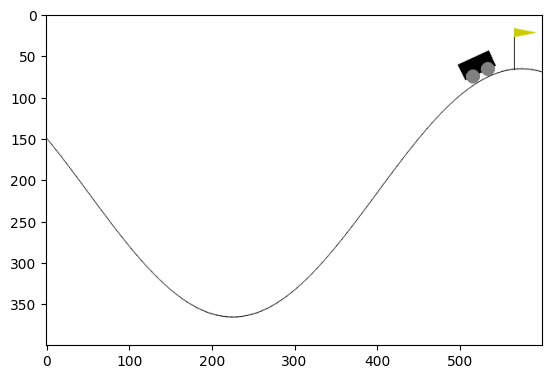

Q-value of the current state left=-13.61 nothing=-12.11 right=-11.59
Action: Right
Q-value of the current state left=-12.70 nothing=-11.33 right=-10.84
Action: Right
Q-value of the current state left=-12.24 nothing=-10.98 right=-10.53
Action: Right
Q-value of the current state left=-11.79 nothing=-10.65 right=-10.23
Action: Right
Q-value of the current state left=-11.36 nothing=-10.33 right=-9.94
Action: Right


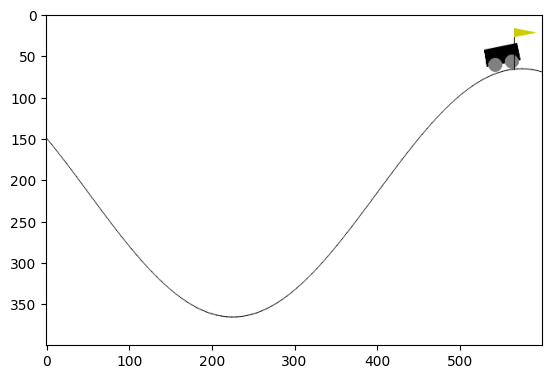

Q-value of the current state left=-10.94 nothing=-10.01 right=-9.66
Action: Right
Q-value of the current state left=-10.53 nothing=-9.71 right=-9.39
Action: Right
Q-value of the current state left=-10.14 nothing=-9.41 right=-9.12
Action: Right


In [22]:
episode_rewards = []
done = False
i = 0

while not done:
    i += 1

    # Display current state
    #plt.imshow(env.render(mode="rgb_array"))
    if(i%5 == 0):
      plt.imshow(env.render())
      plt.show()

    # Retrieve q-value
    q_values = get_q_values(dqn_model, obs)

    # Take greedy-action
    action, _ = dqn_model.predict(obs, deterministic=True)

    print(f"Q-value of the current state left={q_values[0]:.2f} nothing={q_values[1]:.2f} right={q_values[2]:.2f}")
    print(f"Action: {action_str[action]}")

    obs, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

    episode_rewards.append(reward)


### Exercise (3 minutes): compare estimated initial q-value with actual discounted return

Compute the discounted return (sum of discounted reward) of the episode and compare it to the initial estimated q-value.

Note: You will need to use the discount factor `dqn_model.gamma`

In [23]:
sum_discounted_rewards = 0

### YOUR CODE HERE
# Compute the sum of discounted reward for the last episode
# using `episode_rewards` list and `dqn_model.gamma` discount factor
for t, reward in enumerate(episode_rewards):
    sum_discounted_rewards += (dqn_model.gamma ** t) * reward

### END OF YOUR CODE

print(f"Sum discounted rewards: {sum_discounted_rewards:.2f}, initial q-value {initial_q_value:.2f}")

Sum discounted rewards: -64.13, initial q-value -59.90


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.

Concretely, in DQN, the target q-value is defined as:

$$Y^{DQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{target}\right); \mathbb{\theta}_{target}\right)$$

where the target network `q_net_target` with parameters $\mathbb{\theta}_{target}$ is used for both action selection and estimation, and can therefore be rewritten:

$$Y^{DQN}_{t} = r_{t+1} + \gamma \max_{a}{Q}\left(s_{t+1}, a; \mathbb{\theta}_{target}\right)$$

Double DQN uses the online network `q_net` with parameters $\mathbb{\theta}_{online}$ to select the action and the target network `q_net_target` to estimate the associated q-values:

$$Y^{DoubleDQN}_{t} = r_{t+1} + \gamma{Q}\left(s_{t+1}, \arg\max_{a}Q\left(s_{t+1}, a; \mathbb{\theta}_{online}\right); \mathbb{\theta}_{target}\right)$$


The goal in this exercise is for you to write the update method for `DoubleDQN`.

You will need to:

1. Sample replay buffer data using `self.replay_buffer.sample(batch_size)`

2. Compute the Double DQN target q-value using the next observations `replay_data.next_observation`, the online network `self.q_net`, the target network `self.q_net_target`, the rewards `replay_data.rewards` and the termination signals `replay_data.dones`. Be careful with the shape of each object ;)

3. Compute the current q-value estimates using the online network `self.q_net`, the current observations `replay_data.observations` and the buffer actions `replay_data.actions`

4. Compute the loss to train the q-network using L2 or Huber loss (`F.smooth_l1_loss`)


Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



In [24]:
from torch.nn import functional as F

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            ### YOUR CODE HERE
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size)

            # Do not backpropagate gradient to the target network
            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # Decouple action selection from value estimation
                # Compute q-values for the next observation using the online q net
                next_q_values_online = self.q_net(replay_data.next_observations)
                # Select action with online network
                next_actions_online = next_q_values_online.argmax(dim=1, keepdim=True)
                # Estimate the q-values for the selected actions using target q network
                next_q_values = th.gather(next_q_values, dim=1, index=next_actions_online)

                # 1-step TD target
                is_not_dones = 1 - replay_data.dones
                target_q_values = replay_data.rewards + is_not_dones*self.gamma*next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Check the shape
            assert current_q_values.shape == target_q_values.shape

            # Compute loss (L2 or Huber loss)
            loss = F.huber_loss(current_q_values, target_q_values)

            ### END OF YOUR CODE

            losses.append(loss.item())

            # Optimize the q-network
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

## Monitoring Evolution of the Estimated q-value


Here we create a SB3 callback to over-estimate initial q-values and then monitor their evolution over time.

In [25]:
from torch.nn import functional as F

from stable_baselines3.common.callbacks import BaseCallback


class MonitorQValueCallback(BaseCallback):
    """
    Callback to monitor the evolution of the q-value
    for the initial state.
    It allows to artificially over-estimate a q-value for initial states.

    """
    def __init__(self, sample_interval: int = 2500):
        super().__init__()
        self.timesteps = []
        self.max_q_values = []
        self.sample_interval = sample_interval
        n_samples = 512
        env = gym.make("MountainCar-v0")
        # Sample initial states that will be used to monitor the estimated q-value
        #self.start_obs = np.array([env.reset() for _ in range(n_samples)], dtype=np.float)
        # we only take the observation
        self.start_obs = np.array([env.reset()[0] for _ in range(n_samples)], dtype=np.float)


    def _on_training_start(self) -> None:
        # Create overestimation
        start_obs = self.start_obs.astype(np.float)
        obs = th.tensor(start_obs, device=self.model.device).float()
        # Over-estimate going left q-value for the initial states
        target_q_values = th.ones((len(obs), 1), device=self.model.device).float() * 100

        for _ in range(100):
            # Get current Q-values estimates
            current_q_values = self.model.q_net(obs)

            # Over-estimate going left
            current_q_values = th.gather(current_q_values, dim=1, index=th.zeros((len(obs), 1), device=self.model.device).long())

            loss = F.mse_loss(current_q_values, target_q_values)

            # Optimize the policy
            self.model.policy.optimizer.zero_grad()
            loss.backward()
            self.model.policy.optimizer.step()

    def _on_step(self) -> bool:
        # Sample q-values
        if self.n_calls % self.sample_interval == 0:
            # Monitor estimated q-values using current model
            obs = th.tensor(self.start_obs, device=self.model.device).float()
            with th.no_grad():
                q_values = self.model.q_net(obs).cpu().numpy()

            self.logger.record("train/max_q_value", float(q_values.max()))
            self.timesteps.append(self.num_timesteps)
            self.max_q_values.append(q_values.max())
        return True

## Evolution of the q-value with initial over-estimation

### DQN

In [26]:
dqn_model = DQN(
    "MlpPolicy",
    "MountainCar-v0",
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=5000,
    learning_starts=1000,
    buffer_size=25000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=102,
)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Define the callback

In [27]:
monitor_dqn_value_cb = MonitorQValueCallback()

<ipython-input-25-10ff3681c339>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.start_obs = np.array([env.reset()[0] for _ in range(n_samples)], dtype=np.float)


In [28]:
dqn_model.learn(total_timesteps=int(4e4), callback=monitor_dqn_value_cb)

Logging to data/tb/DQN_2


<ipython-input-25-10ff3681c339>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_obs = self.start_obs.astype(np.float)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.907    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1499     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.814    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1107     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.00061  |
|    n_updates        | 296      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

### Double DQN

In [33]:
double_q = DoubleDQN("MlpPolicy",
            "MountainCar-v0",
            verbose=1,
            train_freq=16,
            gradient_steps=8,
            gamma=0.99,
            exploration_fraction=0.2,
            exploration_final_eps=0.07,
            target_update_interval=5000,
            learning_starts=1000,
            buffer_size=25000,
            batch_size=128,
            learning_rate=4e-3,
            policy_kwargs=dict(net_arch=[256, 256]),
            tensorboard_log=tensorboard_log,
            seed=102)

Using cpu device
Creating environment from the given name 'MountainCar-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [34]:
monitor_double_q_value_cb = MonitorQValueCallback()

<ipython-input-25-10ff3681c339>:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.start_obs = np.array([env.reset()[0] for _ in range(n_samples)], dtype=np.float)


In [35]:
double_q.learn(int(4e4), log_interval=10, callback=monitor_double_q_value_cb)

Logging to data/tb/DQN_4


<ipython-input-25-10ff3681c339>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_obs = self.start_obs.astype(np.float)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.767    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 687      |
|    time_elapsed     | 2        |
|    total_timesteps  | 2000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.264    |
|    n_updates        | 496      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -200     |
|    exploration_rate | 0.535    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 620      |
|    time_elapsed     | 6        |
|    total_timesteps  | 4000     |
| train/              |          |
|    learning_rate    | 0.004    |
|    loss             | 0.177    |
|    max_q_value    

### Evolution of the max q-value for start states over time

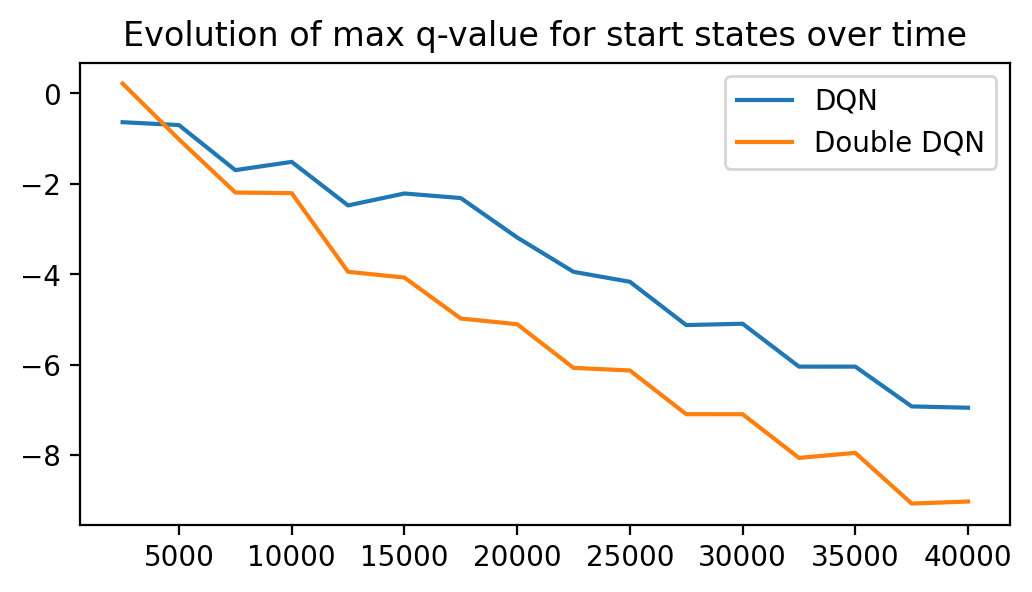

In [36]:
plt.figure(figsize=(6, 3), dpi=200)
plt.title("Evolution of max q-value for start states over time")
plt.plot(monitor_dqn_value_cb.timesteps, monitor_dqn_value_cb.max_q_values, label="DQN")
plt.plot(monitor_double_q_value_cb.timesteps, monitor_double_q_value_cb.max_q_values, label="Double DQN")
plt.legend()